In [204]:
from skimage import io, color, feature, measure,img_as_float,exposure,filters,morphology,transform
from skimage.util import invert
from skimage.filters import threshold_otsu
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score

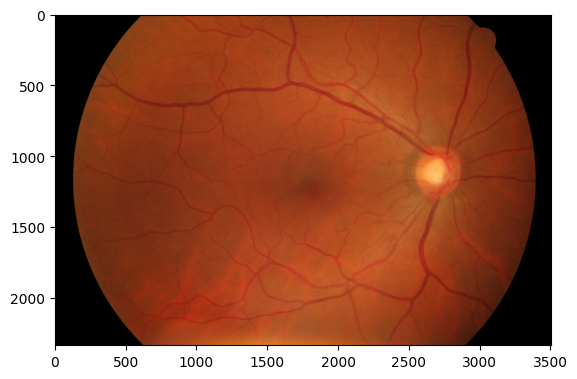

In [69]:
# read image from disk into a numpy array, provide the correct path 
im_fundus = io.imread("15_h.jpg") 
# display the image
plt.imshow(im_fundus) 
plt.show() 

(np.float64(-0.5), np.float64(3503.5), np.float64(2335.5), np.float64(-0.5))

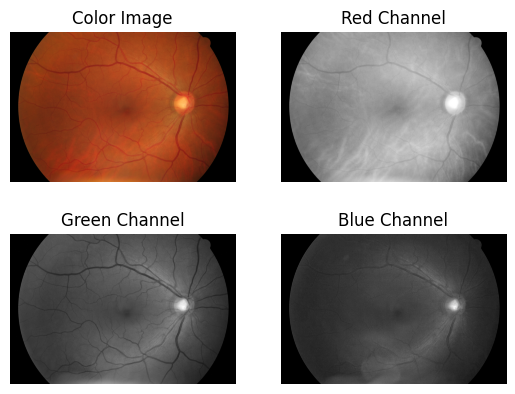

In [141]:
#display each color channel
plt.subplot(221); plt.imshow(im_fundus); plt.title('Color Image'); plt.axis('off')
plt.subplot(222); plt.imshow(im_fundus[:,:,0],cmap='gray'); plt.title('Red Channel'); plt.axis('off')
plt.subplot(223); plt.imshow(im_fundus[:,:,1],cmap='gray'); plt.title('Green Channel'); plt.axis('off')
plt.subplot(224); plt.imshow(im_fundus[:,:,2],cmap='gray'); plt.title('Blue Channel'); plt.axis('off')

(np.float64(-0.5), np.float64(3503.5), np.float64(2335.5), np.float64(-0.5))

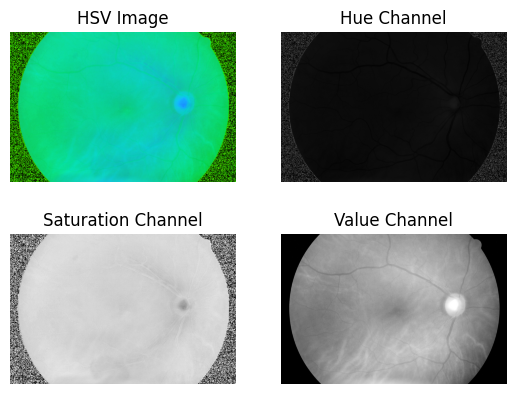

In [142]:
imhsv_fundus = color.rgb2hsv(im_fundus) # from RGB to HSV color space # change the saturation
plt.subplot(221); plt.imshow(imhsv_fundus); plt.title('HSV Image'); plt.axis('off')
plt.subplot(222); plt.imshow(imhsv_fundus[:,:,0],cmap='gray'); plt.title('Hue Channel'); plt.axis('off')
plt.subplot(223); plt.imshow(imhsv_fundus[:,:,1],cmap='gray'); plt.title('Saturation Channel'); plt.axis('off')
plt.subplot(224); plt.imshow(imhsv_fundus[:,:,2],cmap='gray'); plt.title('Value Channel'); plt.axis('off')

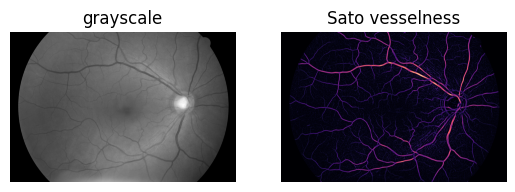

In [180]:
im_gray =color.rgb2gray(im_fundus) # convert to grayscale
t0, t1 = filters.threshold_multiotsu(im_gray, classes=3) # apply Otsu's method to find thresholds
# create a mask for the vessels
mask = im_gray > t0
vessels = filters.sato(im_gray, sigmas=range(1, 10)) * mask

_, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(im_gray, cmap='gray')
axes[0].set_axis_off()
axes[0].set_title('grayscale')
axes[1].imshow(vessels, cmap='magma')
axes[1].set_axis_off()
_ = axes[1].set_title('Sato vesselness')


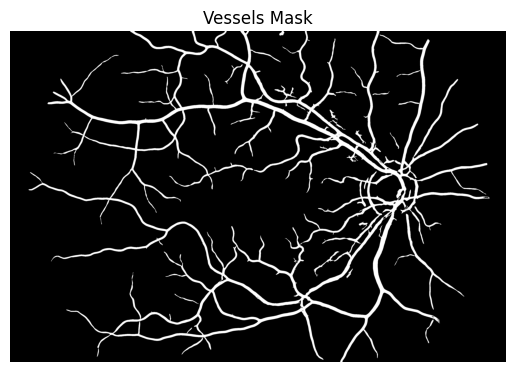

In [168]:
vessels_mask = vessels > 0.007 # create a mask for the vessels
vessels_mask = morphology.remove_small_objects(vessels_mask, min_size=700) # remove small objects from the mask
plt.imshow(vessels_mask, cmap='gray'); 
plt.title('Vessels Mask'); 
plt.axis('off')
plt.show() # display the binary mask

Text(0.5, 1.0, 'Vessels Mask Overlay')

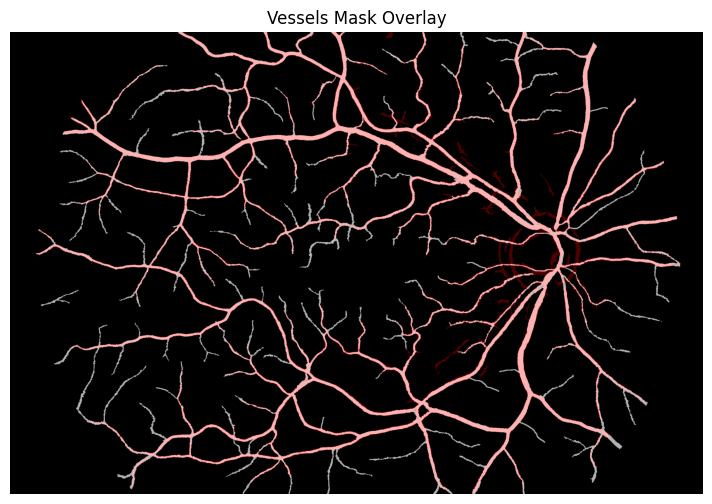

In [ ]:
im_vessels = io.imread("C:\\Users\\Celeste_ICY\\Desktop\\healthy_manualsegm\\15_h.tif") # read the manual segmentation image
image_label_overlay = color.label2rgb(vessels_mask, image=im_vessels, bg_label=0) #overlay segmentation over the manual seg image
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)
ax.axis('off')
ax.set_title('Vessels Mask Overlay')

In [171]:
im_vessels = (im_vessels > 0.5).astype(int)
vessels_mask = (vessels_mask > 0.5).astype(int)
y_true = im_vessels.flatten()
y_pred = vessels_mask.flatten()

# Compute Dice Coefficient
intersection = np.sum(y_true * y_pred)
dice = (2. * intersection) / (np.sum(y_true) + np.sum(y_pred))

# Compute Jaccard Index (IoU)
jaccard = jaccard_score(y_true, y_pred)

# Print the results
print(f"Dice Coefficient: {dice:.4f}")
print(f"Jaccard Index (IoU): {jaccard:.4f}")

Dice Coefficient: 0.7710
Jaccard Index (IoU): 0.6274


(np.float64(-0.5), np.float64(3503.5), np.float64(2335.5), np.float64(-0.5))

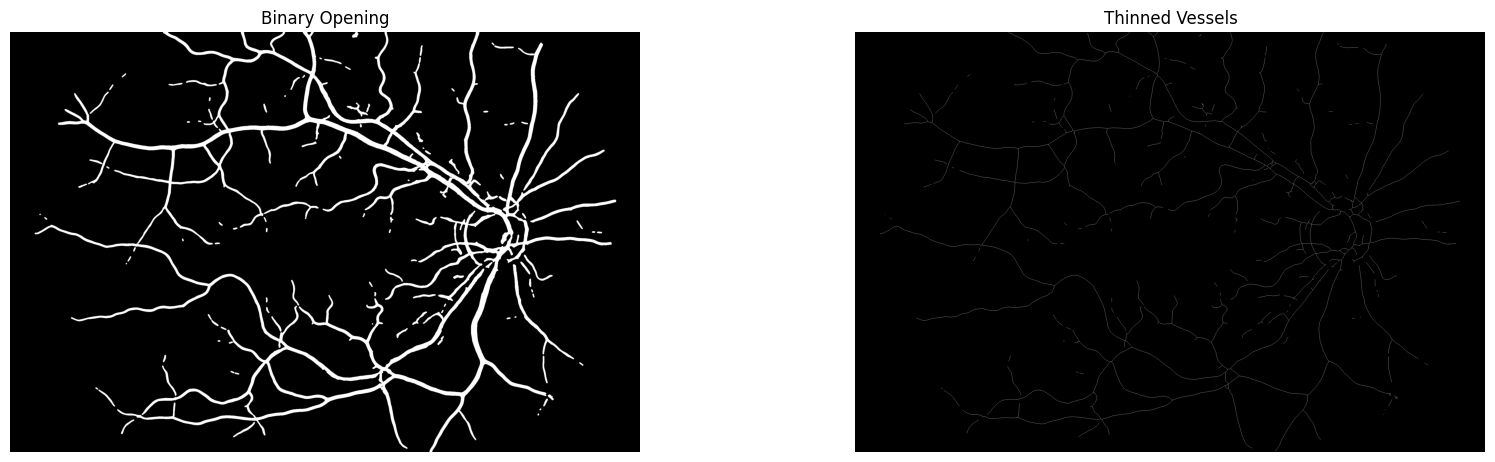

In [ ]:
se = morphology.disk(4)
im_open = morphology.binary_opening(vessels_mask,se) # perform binary opening to remove smaller vessels (less than 8 pixels wide)
im_thinned = morphology.thin(im_open) # perform thinning to reduce the vessels to a single pixel width

plt.figure(figsize=(20,12))
plt.subplot(221); plt.imshow(im_open, cmap='gray'); plt.title('Binary Opening'); plt.axis('off')
plt.subplot(222); plt.imshow(im_thinned, cmap='gray'); plt.title('Thinned Vessels'); plt.axis('off')

In [187]:
num_pixels = np.sum((im_thinned > 0.5).astype(int)) # count the number of pixels in the thinned mask
print(f"Overall length of the vascular network(in pixels): {num_pixels}") # print the number of pixels

Overall length of the vascular network(in pixels): 35786


Length of vessels with width > 20 pixels: 7304


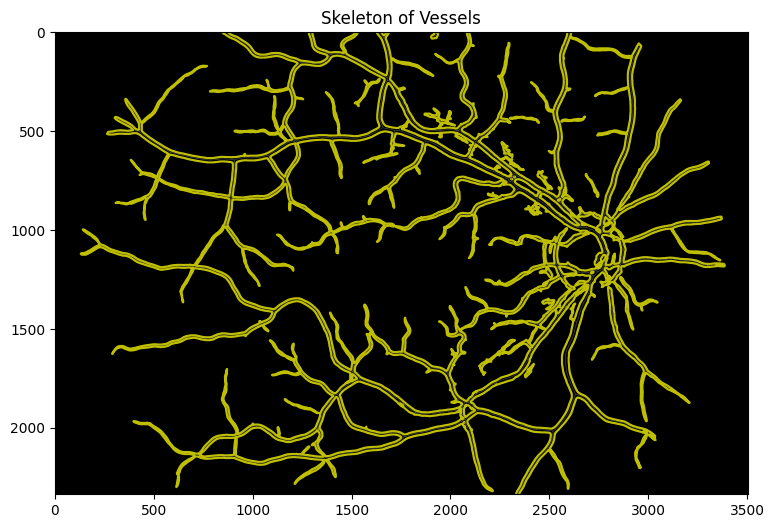

In [ ]:
vessels_sk, distance = morphology.medial_axis(vessels_mask, return_distance=True) # perform medial axis transformation on the vessels mask
dist_on_skel = distance * vessels_sk # compute the distance on the skeleton

# Keep only skeleton points with width > 20
mask_thick_vessels = (2 * dist_on_skel) > 20

# Count how many thick vessel pixels
length_thick_vessels = np.sum(mask_thick_vessels)
print(f"Length of vessels with width > 20 pixels: {length_thick_vessels}")
plt.figure(figsize=(10,6))
plt.imshow(vessels_sk, cmap='gray'),
plt.title("Skeleton of Vessels")
plt.contour(vessels_mask, [0.5], colors='y')

(20,)
[7 2 4 6 7 0 0 0 0 1 0 1 0 1 4 4 4 6 0 3]


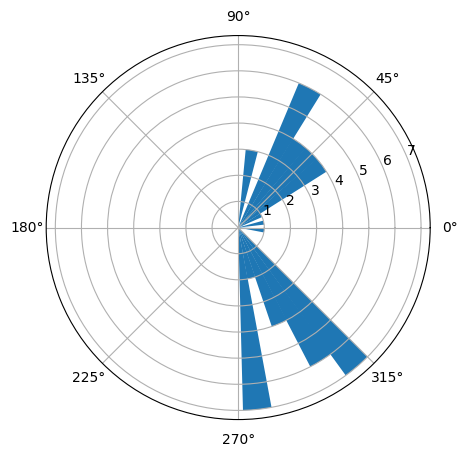

In [ ]:
# canny edge detection
im_edges  = feature.canny(im_vessels, sigma=2,low_threshold=10, high_threshold=50)
im_edges = im_edges[2:im_vessels.shape[0]-2,2:im_vessels.shape[1]-2]

# Hough transforms to find lines on the edge detection results
[H, theta, rho] = transform.hough_line(im_edges); 
hspace, angles, dists = transform.hough_line_peaks(H, theta, rho,num_peaks=50)

#Display the orientation distribution of the vascular network in a polar (rose) plot.
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)
N = 20
radii = np.histogram(angles,bins=N)
atheta = np.linspace(min(angles), max(angles), N)
print(atheta.shape)
print(radii[0])

width = np.pi/N 
bars = plt.bar(atheta, radii[0], width=width, bottom=0.0)
